In [1]:
import sys

import torch
from torchvision import transforms
import zarr
import pandas as pd
import skimage
from PIL import Image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torchxrayvision as xrv

sys.path.append('../')
import visualfeaturesearch as vfs
from visualfeaturesearch.searchtool import CachedSearchTool

# use the Apple M1 GPU
device = torch.device('mps')

In [3]:
model = xrv.models.DenseNet(weights='densenet121-res224-all').to(device)
model.op_threshs = torch.tensor(xrv.models.model_urls['all']['ppv80_thres']).to(device)
model_feats = model.features # get the final feature tensors (of shape 1024x7x7)
model_feats = model_feats.eval().to(device)

cache_store = zarr.DirectoryStore('../../MedImaging/XRV_DenseNet_ALL_08242023')
cache_root = zarr.group(store=cache_store, overwrite=False)
cache_feats_data = np.float32(cache_root['feats'][:])

cached_search_tool = CachedSearchTool(model_feats, cache_feats_data, device, batch_size=5000)

In [5]:
nih_csv = pd.read_csv('../../MedImaging/CXR8/Data_Entry_2017_v2020.csv')
nih_csv = nih_csv[:4999]

transform = transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(224)
])

def get_nih_image(idx):
  query_img_name = nih_csv.iloc[idx]['Image Index']
  query_img = skimage.io.imread(f'../../MedImaging/CXR8/images/images/{query_img_name}')
  query_img_model = xrv.datasets.normalize(query_img, 255, reshape=True)
  query_img_model = torch.as_tensor(transform(query_img_model))
  return query_img_model

def model_img_to_PIL(img):
  img_vis = (img + 1024) / 2048 * 255
  img_vis = Image.fromarray(np.uint8(img_vis[0,:,:]))
  return img_vis

Setting XRayResizer engine to cv2 could increase performance.


In [6]:
QUERY_IDXS = list(range(0, 2000, 200))

model_imgs = [get_nih_image(idx) for idx in QUERY_IDXS]
vis_imgs = [model_img_to_PIL(img).convert('RGB') for img in model_imgs]
query_img_urls = [vfs.util.image_to_durl(img) for img in vis_imgs]

highlight_data = None
highlight_index = None
test_data = None
def highlight_callback(data):
    global highlight_data, highlight_index
    if isinstance(data, str): # the data get returned in different formats for Colab and Jupyter notebook
        data = data.rsplit(',', 1)
    highlight_data = data[0]
    highlight_index = int(data[1])
vfs.util.create_callback('highlight_callback', highlight_callback)

vfs.widgets.MultiHighlightWidget(all_urls=query_img_urls, callback_name='highlight_callback')

In [7]:
assert highlight_data is not None, "Use the widget to highlight an image region"

selected_idx = int(highlight_index)
mask = vfs.util.durl_to_image(highlight_data)

cached_search_tool.set_input_image(model_imgs[selected_idx])

# turn the user's highlighted mask into a 7x7 grayscale array
mask_transform = transforms.Resize(7)
mask_7x7 = mask_transform(mask)
mask_7x7_arr = np.asarray(mask_7x7)[:,:,3] / 255
mask_7x7_arr = np.float32(mask_7x7_arr)

print('Loading results...')
region_sims, region_xs, region_ys = cached_search_tool.compute(mask_7x7_arr)
sim_order = torch.argsort(region_sims, descending=True)
print('Done.')

nih_csv['Cosine Similarity'] = region_sims.cpu().numpy()
sorted_csv = nih_csv.sort_values(by='Cosine Similarity', ascending=False).reset_index()
sorted_csv[:6][['Finding Labels', 'Patient ID', 'Patient Age', 'Patient Gender', 'Cosine Similarity']]

Loading results...
Done.


,Finding Labels,Patient ID,Patient Age,Patient Gender,Cosine Similarity
0,Cardiomegaly,1,57,M,0.999997
1,Cardiomegaly|Effusion,38,75,M,0.924002
2,Cardiomegaly|Emphysema,968,68,F,0.906014
3,Cardiomegaly,845,65,F,0.901916
4,Infiltration,131,63,M,0.900410
5,No Finding,1296,59,M,0.898759


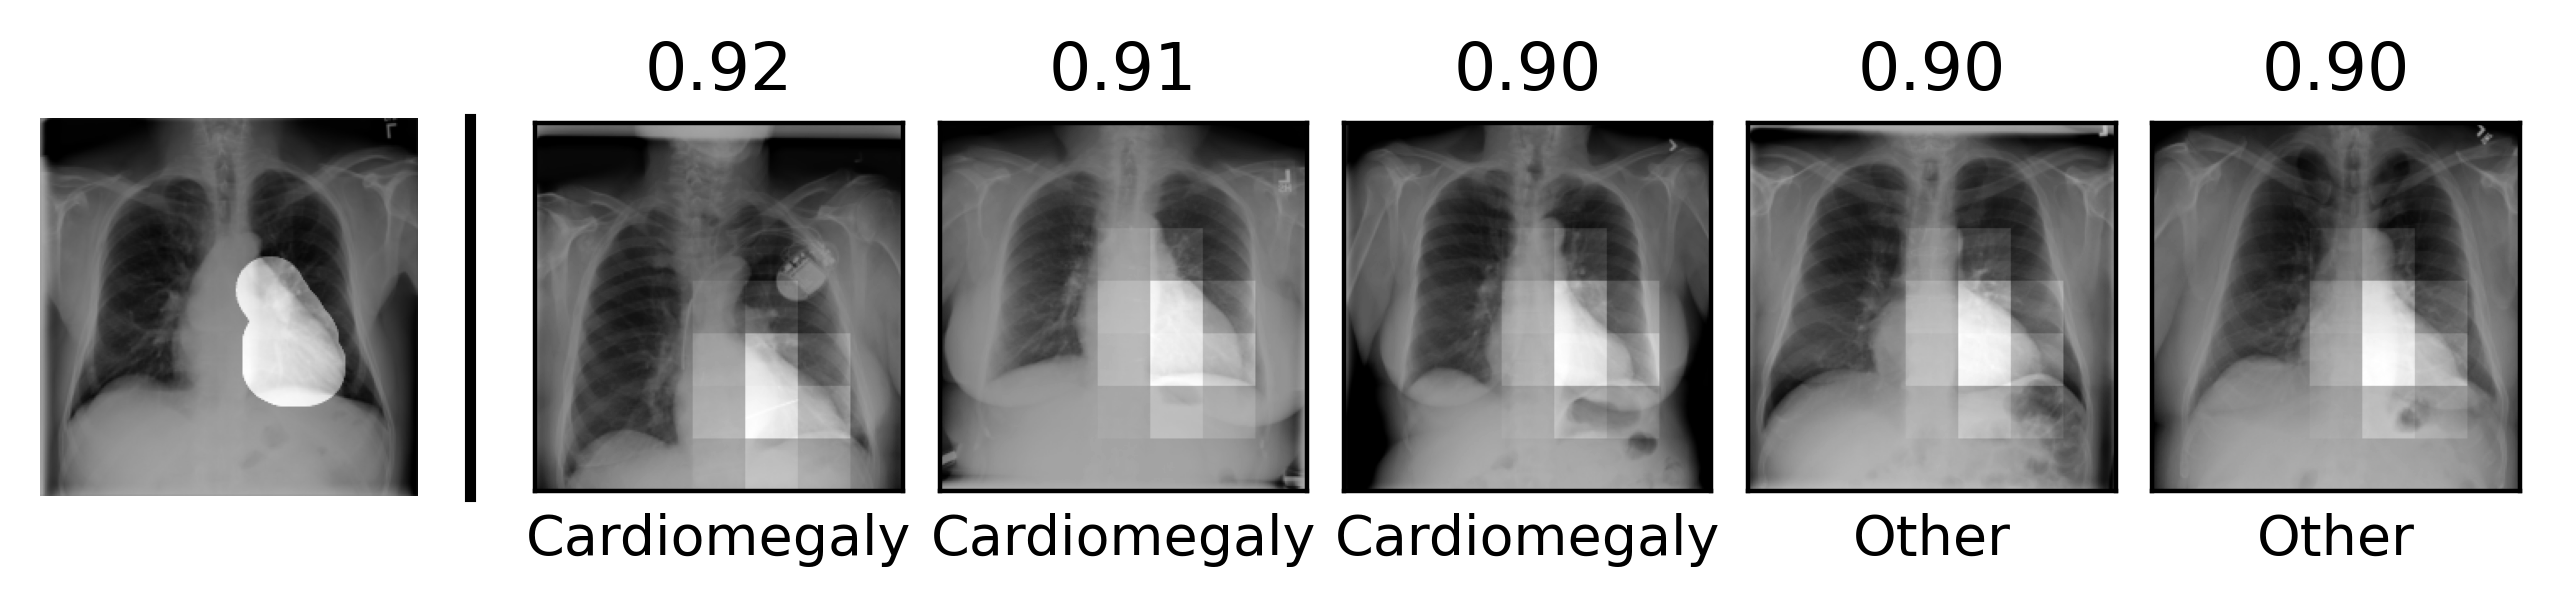

In [8]:
# set up the figure
DISPLAY_NUM = 5

fig = plt.figure(figsize=(8, 5.15), dpi=400)
# fig.suptitle('Nearest Neighbors', fontweight='bold', y=0.75)
gs = fig.add_gridspec(1,2, width_ratios=[0.95,5])
fig.subplots_adjust(wspace=0.1, hspace=0)
results_gs = gs[1].subgridspec(1,DISPLAY_NUM)

# show the query region on the left-hand side
ax = fig.add_subplot(gs[0])
ax.axis('off')
ax.imshow(vfs.util.mask_overlay(vis_imgs[selected_idx], 0, 0, 224, np.asarray(mask)[:,:,3] / 256))
line_x_val = 255
ax.add_line(matplotlib.lines.Line2D([line_x_val,line_x_val], [0,224], lw=2, color='black')).set_clip_on(False)

# include the most similar images from the dataset on the right side
for i in range(DISPLAY_NUM):
  idx = sim_order[i+1].cpu().numpy()
  img = model_img_to_PIL(get_nih_image(idx))
  curr_img_out = vfs.util.mask_overlay(img,
                                   x=region_xs[idx],
                                   y=region_ys[idx],
                                   mask_size=7,
                                   mask=vfs.util.crop_mask(mask_7x7_arr))

  ax = fig.add_subplot(results_gs[i])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(curr_img_out, cmap='gray')
  ax.set_title( f'{region_sims[idx].cpu().numpy():.02f}')
  sub_str = 'Cardiomegaly' if 'Cardiomegaly' in sorted_csv.iloc[i+1]["Finding Labels"] else 'Other'
  ax.set_xlabel(f'{sub_str}')

Text(0, 0.5, 'Cardiomegaly\nPresent')

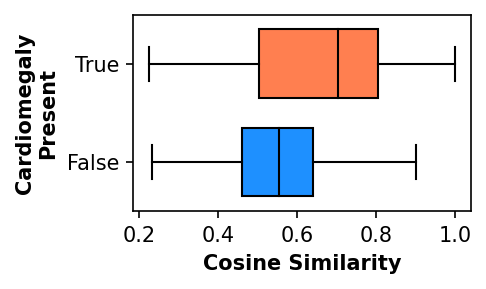

In [13]:
sorted_csv['Cardiomegaly Present'] = sorted_csv['Finding Labels'].str.contains('Cardiomegaly')

sims_with_cardiomegaly = sorted_csv[sorted_csv['Cardiomegaly Present']]['Cosine Similarity'].to_numpy()
sims_without_cardiomegaly = sorted_csv[sorted_csv['Cardiomegaly Present'] == False]['Cosine Similarity'].to_numpy()
plt.figure(figsize=(2.9, 1.7), dpi=150)

boxplot = plt.boxplot(x=[sims_without_cardiomegaly, sims_with_cardiomegaly], 
            labels=[False, True], vert=False, widths=.7, patch_artist=True)
for median in boxplot['medians']:
    median.set_color('black')
    
colors = ['dodgerblue', 'coral']
for i in range(2):
    boxplot['boxes'][i].set_facecolor(colors[i])
    
plt.xticks([0.2, 0.4, 0.6, 0.8, 1.0])
plt.xlabel('Cosine Similarity', fontweight='bold')
plt.ylabel('Cardiomegaly\nPresent', fontweight='bold')